# FTIR Classification Using Supervised VQ-VAE

In [1]:
%load_ext autoreload
%autoreload 2

import os
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import tensorflow as tf

%load_ext tensorboard

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2023-01-18 14:36:33.217784: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-18 14:36:33.352449: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-18 14:36:33.979918: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/yoyo/Documents/TensorRT-5.0.2.6/lib
2023-01-18 14:36:33.979971: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_p

In [2]:
from model.vqvae import VectorQuantizer, VQVAETrainer, VQSVAETrainer

from model.dataset import UnlabelSpectraDataset, DataGeneratorAE

from utils import show_reconstruction, show_reconstruction_codebook, multilabel_classification_report_pred, unknown_prediction_report

#### EXP: **User Param**

In [3]:
data_dir = 'data'
latent_dim = 16
num_embeddings = 128
batch_size = 32
epoch = 200

In [4]:
logdir = "logs/vqsvae/" + datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(logdir + "/train")

with file_writer.as_default():
    tf.summary.scalar('latent_dim', data=latent_dim, step=epoch)
    tf.summary.scalar('num_embeddings', data=num_embeddings, step=epoch)

2023-01-18 14:36:35.289852: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Step 1: Train VQ-VQE Model on Unlabeled Data

### Prepare Dataset

In [5]:
unlabel_dataset = UnlabelSpectraDataset(data_dir)

Reading unlabel data
Read 452 unlabeled spectra for training.
No. of data points/shifts per spectra (input shape) : (1792,)


In [6]:
unlabel_dataset.get_training_data().shape

(452, 1792)

In [7]:
unlabel_datagen = DataGeneratorAE(unlabel_dataset, batch_size=batch_size)

In [8]:
unlabel_datagen[0].shape

(32, 1792, 1)

Create the encoder and the decoder for the VQ-VAE and the VQ-VAE itself. 

In [9]:
input_shape = (unlabel_dataset.get_input_shape()[0], 1)

In [10]:
input_shape

(1792, 1)

#### EXP: Encoder/Decoder Architecture

In [11]:
from model.vqvae import get_encoder_4conv3, encoder_4conv3_str, get_decoder_4conv3, decoder_4conv3_str

In [12]:
def get_vqvae(encoder_input_shape, latent_dim=16, num_embeddings=64):
    vq_layer = VectorQuantizer(num_embeddings, latent_dim, name="vector_quantizer")
    encoder = get_encoder_4conv3(encoder_input_shape, latent_dim)
    encoder.summary()
    decoder_input_shape = encoder.output.shape[1:]
    decoder = get_decoder_4conv3(decoder_input_shape, latent_dim)
    decoder.summary()
    inputs = keras.Input(shape=input_shape)
    encoder_outputs = encoder(inputs)
    quantized_latents = vq_layer(encoder_outputs)
    reconstructions = decoder(quantized_latents)
    return keras.Model(inputs, reconstructions, name="vq_vae")

# get_vqvae(input_shape, latent_dim, num_embeddings).summary()

In [13]:
data_variance = np.var(unlabel_dataset.train_data.values)
data_variance

0.02517854

In [14]:
with file_writer.as_default():
    tf.summary.text("encoder", encoder_4conv3_str, step=epoch)
    tf.summary.text("decoder", decoder_4conv3_str, step=epoch)
    tf.summary.text("vqvae_optimizer", "adam", step=epoch)

In [15]:
vqvae_trainer = VQVAETrainer(get_vqvae, data_variance, input_shape, latent_dim=latent_dim, num_embeddings=num_embeddings)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam())

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1792, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 896, 16)           64        
                                                                 
 conv1d_1 (Conv1D)           (None, 448, 32)           1568      
                                                                 
 conv1d_2 (Conv1D)           (None, 224, 48)           4656      
                                                                 
 conv1d_3 (Conv1D)           (None, 112, 64)           9280      
                                                                 
 conv1d_4 (Conv1D)           (None, 112, 16)           1040      
                                                                 
Total params: 16,608
Trainable params: 16,608
Non-trainable

Reconstruction results on the train set

In [16]:
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [17]:
vqvae_trainer.fit(unlabel_datagen, epochs=epoch, callbacks=[tensorboard_callback],)

Epoch 1/200
14/14 [==============================] - 2s 17ms/step - e_loss: 6.3500 - e_reconstruction_loss: 6.3478 - e_vqvae_loss: 0.0022
Epoch 2/200
14/14 [==============================] - 0s 16ms/step - e_loss: 5.2586 - e_reconstruction_loss: 5.1463 - e_vqvae_loss: 0.1123
Epoch 3/200
14/14 [==============================] - 0s 18ms/step - e_loss: 5.3201 - e_reconstruction_loss: 2.7674 - e_vqvae_loss: 2.5526
Epoch 4/200
14/14 [==============================] - 0s 16ms/step - e_loss: 7.5156 - e_reconstruction_loss: 1.4262 - e_vqvae_loss: 6.0894
Epoch 5/200
14/14 [==============================] - 0s 15ms/step - e_loss: 2.0726 - e_reconstruction_loss: 1.3551 - e_vqvae_loss: 0.7176
Epoch 6/200
14/14 [==============================] - 0s 16ms/step - e_loss: 0.8318 - e_reconstruction_loss: 0.7980 - e_vqvae_loss: 0.0338
Epoch 7/200
14/14 [==============================] - 0s 15ms/step - e_loss: 0.4524 - e_reconstruction_loss: 0.3992 - e_vqvae_loss: 0.0532
Epoch 8/200
14/14 [===============

#### EXP: VQ-VAE Loss

Reconstruction results on the unlabeled set and visualizing the discrete codes

15/15 [==============================] - 0s 4ms/step
Codebook size is 112


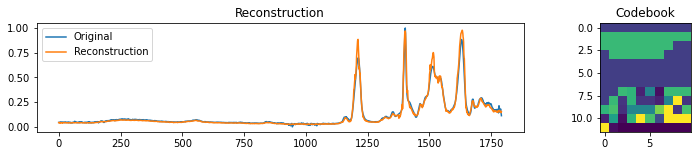

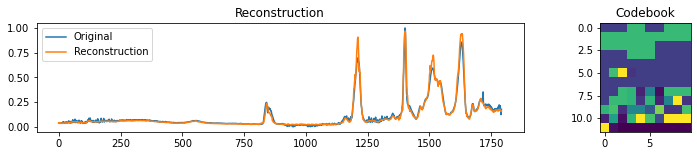

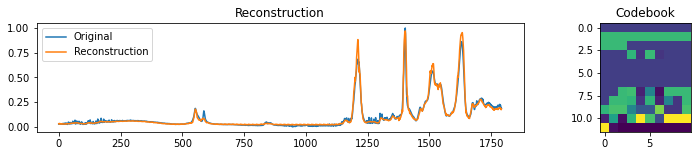

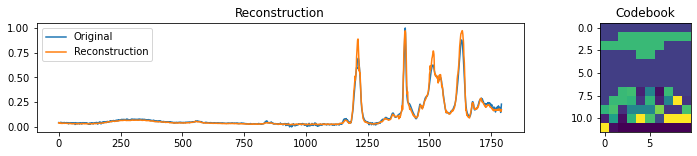

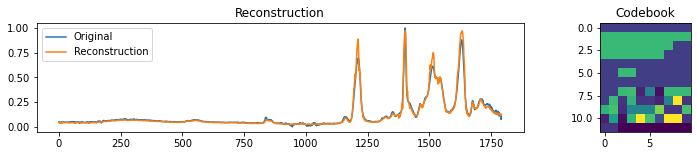

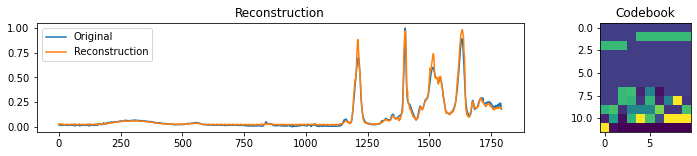

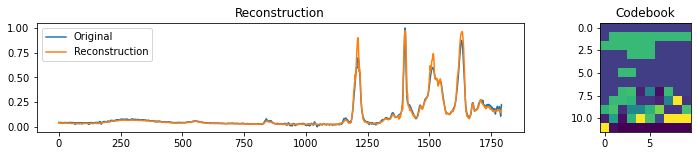

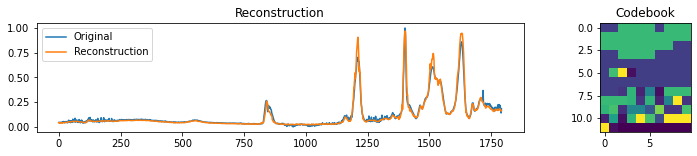

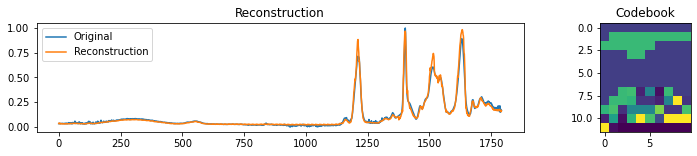

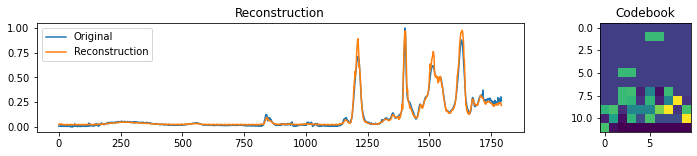

In [18]:
show_reconstruction_codebook(unlabel_dataset.train_data.values, vqvae_trainer.vqvae, (12,10))

## Step 2: Train Classifier

In [19]:
from model.dataset import SpectraDataset, DataGeneratorSAE

### Prepare Dataset

In [20]:
label_dataset = SpectraDataset(data_dir)

Reading train data
No. of materials : 22
[['Acrylic' '6']
 ['ENR' '6']
 ['EPDM' '6']
 ['HDPE' '6']
 ['LDPE' '6']
 ['Nylon' '6']
 ['PBAT' '6']
 ['PBS' '6']
 ['PC' '6']
 ['PEEK' '6']
 ['PEI' '6']
 ['PET' '6']
 ['PLA' '6']
 ['PMMA' '6']
 ['POM' '6']
 ['PP' '6']
 ['PS' '6']
 ['PTEE' '6']
 ['PU' '6']
 ['PVA' '6']
 ['PVC' '6']
 ['cellulose' '6']]
Read 132 spectra for training.
No. of data points/shifts per spectra (input shape) : (1792,)
No. of classes : 22
Reading test data
Read 88 spectra for testing.


In [21]:
label_dataset.get_binary_targets().shape

(132, 22)

In [22]:
label_dataset.get_training_data().shape

(132, 1792)

In [23]:
label_datagen = DataGeneratorSAE(label_dataset)

In [24]:
label_datagen[0][0].shape

(32, 1792, 1)

In [25]:
label_datagen[0][1].shape

(32, 22)

### Create the VQ-SVAE

In [26]:
num_class = label_dataset.get_num_class()

In [27]:
from model.vqvae import get_classifier_tanh, classifier_tanh_str

In [28]:
def get_vqsvae(vqvae, encoder_input_shape, num_class, latent_dim=16, num_embeddings=64):
    vq_layer = VectorQuantizer(num_embeddings, latent_dim, name="vector_quantizer")
    vq_layer.set_weights(vqvae.get_layer("vector_quantizer").get_weights())
    # vq_layer.trainable = False
    encoder = get_encoder_4conv3(encoder_input_shape, latent_dim)
    encoder.set_weights(vqvae.get_layer("encoder").get_weights())
    # encoder.trainable = False
    encoder.summary()
    decoder_input_shape = encoder.output.shape[1:]
    decoder = get_decoder_4conv3(decoder_input_shape, latent_dim)
    decoder.set_weights(vqvae.get_layer("decoder").get_weights())
    # decoder.trainable = False
    decoder.summary()
    classifier = get_classifier_tanh(decoder_input_shape, num_class, latent_dim)
    classifier.summary()
    inputs = keras.Input(shape=input_shape)
    encoder_outputs = encoder(inputs)
    quantized_latents = vq_layer(encoder_outputs)
    reconstructions = decoder(quantized_latents)
    classification = classifier(quantized_latents)
    return keras.Model(inputs, [reconstructions, classification], name="vq_vae")

# get_vqsvae(input_shape, 22, latent_dim=latent_dim, num_embeddings=num_embeddings).summary()

In [29]:
data_variance = np.var(label_dataset.train_data.values)
data_variance

0.028883614

In [30]:
vqsvae_trainer = VQSVAETrainer(get_vqsvae, vqvae_trainer.vqvae, data_variance, input_shape, num_class, latent_dim=latent_dim, num_embeddings=num_embeddings)
vqsvae_trainer.compile(optimizer=keras.optimizers.experimental.AdamW(learning_rate=0.005))

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1792, 1)]         0         
                                                                 
 conv1d_6 (Conv1D)           (None, 896, 16)           64        
                                                                 
 conv1d_7 (Conv1D)           (None, 448, 32)           1568      
                                                                 
 conv1d_8 (Conv1D)           (None, 224, 48)           4656      
                                                                 
 conv1d_9 (Conv1D)           (None, 112, 64)           9280      
                                                                 
 conv1d_10 (Conv1D)          (None, 112, 16)           1040      
                                                                 
Total params: 16,608
Trainable params: 16,608
Non-trainable

In [31]:
with file_writer.as_default():
    tf.summary.text("classifier", classifier_tanh_str, step=epoch)
    tf.summary.scalar('alpha', data=vqsvae_trainer.alpha, step=epoch)

In [32]:
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [33]:
vqsvae_trainer.fit(label_datagen, epochs=epoch, callbacks=[tensorboard_callback])

Epoch 1/200
4/4 [==============================] - 4s 20ms/step - s_loss: 8.0060 - s_reconstruction_loss: 0.6766 - s_vqsvae_loss: 1.1117 - s_clf_loss: 0.6218 - s_clf_bac: 0.7252
Epoch 2/200
4/4 [==============================] - 0s 19ms/step - s_loss: 3.3983 - s_reconstruction_loss: 0.3800 - s_vqsvae_loss: 0.8701 - s_clf_loss: 0.2148 - s_clf_bac: 0.9545
Epoch 3/200
4/4 [==============================] - 0s 16ms/step - s_loss: 5.6402 - s_reconstruction_loss: 0.4012 - s_vqsvae_loss: 3.4519 - s_clf_loss: 0.1787 - s_clf_bac: 0.9545
Epoch 4/200
4/4 [==============================] - 0s 16ms/step - s_loss: 5.1801 - s_reconstruction_loss: 0.3250 - s_vqsvae_loss: 3.0885 - s_clf_loss: 0.1767 - s_clf_bac: 0.9545
Epoch 5/200
4/4 [==============================] - 0s 16ms/step - s_loss: 4.0748 - s_reconstruction_loss: 0.3145 - s_vqsvae_loss: 2.0823 - s_clf_loss: 0.1678 - s_clf_bac: 0.9549
Epoch 6/200
4/4 [==============================] - 0s 17ms/step - s_loss: 2.9725 - s_reconstruction_loss: 0.27

#### EXP: VQ-SVAE Loss

Sanity check: Reconstruction results on the training set and visualizing the discrete codes

5/5 [==============================] - 0s 4ms/step
Codebook size is 112


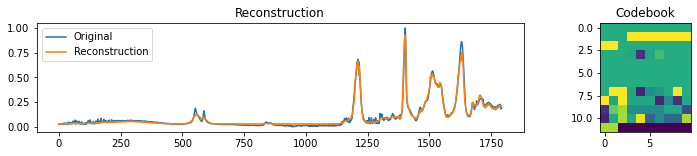

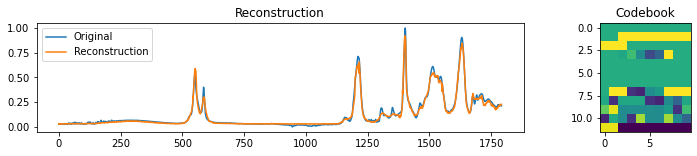

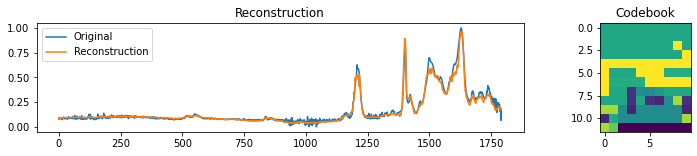

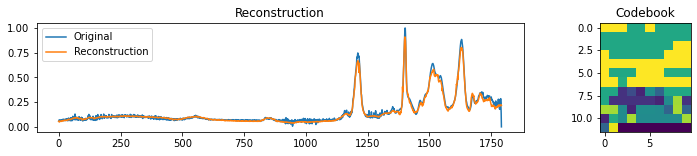

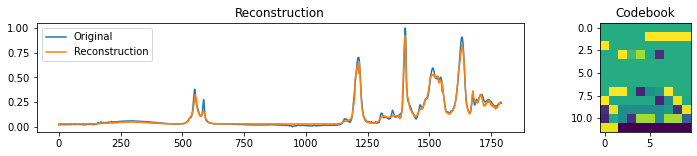

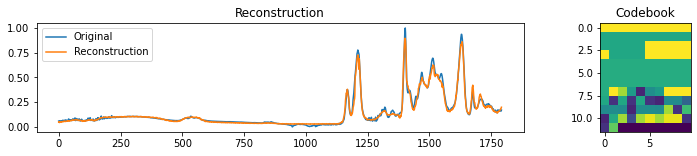

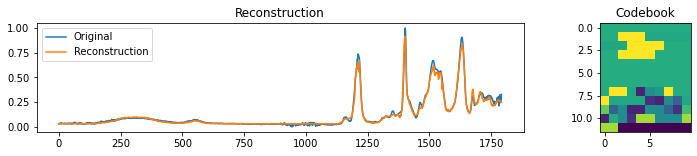

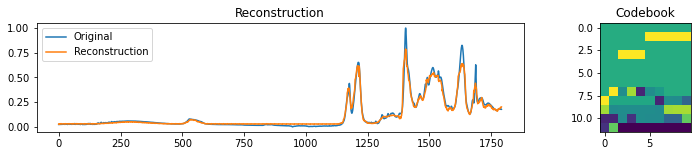

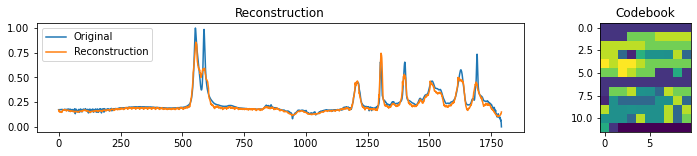

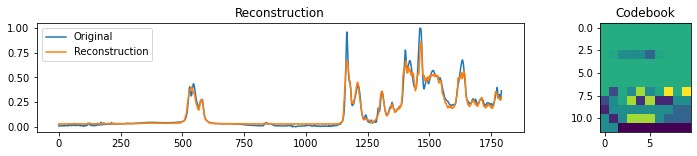

In [34]:
show_reconstruction_codebook(label_dataset.train_data.values, vqsvae_trainer.vqsvae, (12,10))

Sanity check: Reconstruction results on the test set and visualizing the discrete codes

3/3 [==============================] - 0s 4ms/step
Codebook size is 112


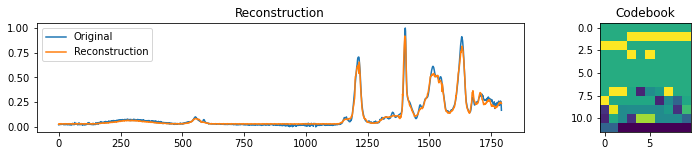

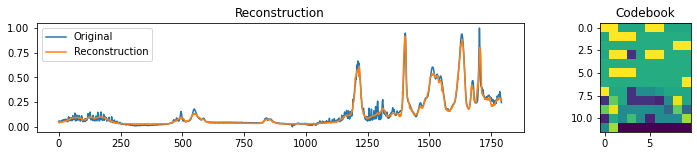

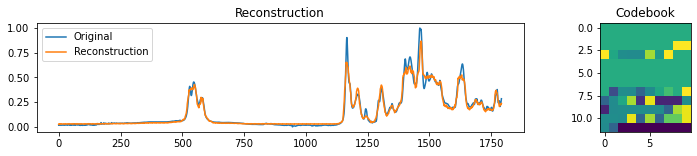

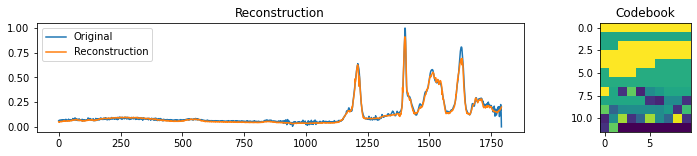

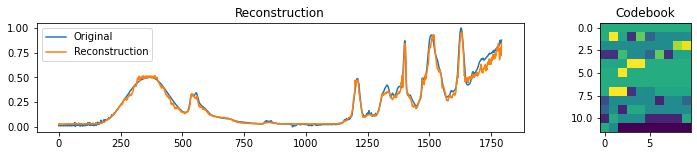

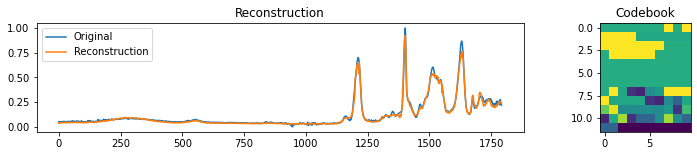

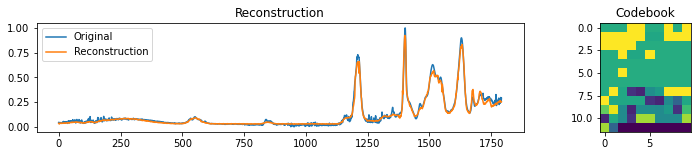

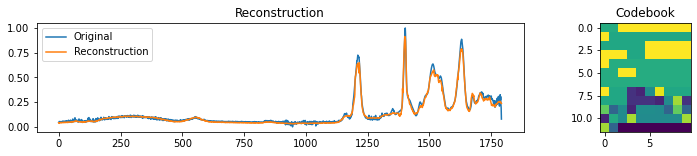

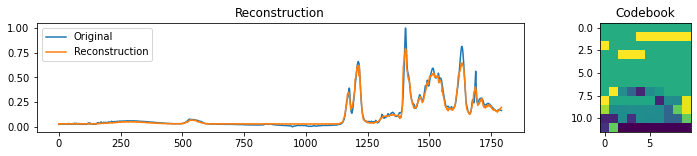

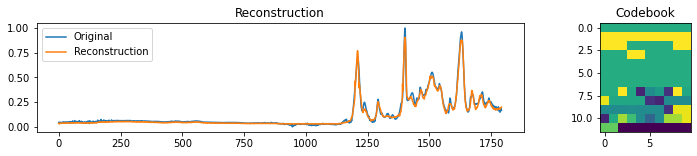

In [35]:
X_test, y_test = label_dataset.get_test_data()
show_reconstruction_codebook(X_test, vqsvae_trainer.vqsvae, (12,10))

In [36]:
reconstructions_test, classification_test = vqsvae_trainer.vqsvae.predict(X_test)

3/3 [==============================] - 0s 8ms/step


#### EXP: VQ-SVAE Results

In [37]:
report = multilabel_classification_report_pred(y_test, classification_test, label_dataset.class_name)

Accuracy:  64 / 88
            precision     recall   f1-score    support
Acrylic          0.43       0.75       0.55          4
ENR              1.00       1.00       1.00          4
EPDM             1.00       1.00       1.00          4
HDPE             0.67       1.00       0.80          4
LDPE             1.00       0.50       0.67          4
Nylon            1.00       0.75       0.86          4
PBAT             1.00       1.00       1.00          4
PBS              1.00       0.25       0.40          4
PC               1.00       0.75       0.86          4
PEEK             1.00       0.75       0.86          4
PEI              1.00       0.75       0.86          4
PET              0.75       0.75       0.75          4
PLA              0.50       1.00       0.67          4
PMMA             1.00       0.75       0.86          4
POM              0.00       0.00       0.00          4
PP               0.00       0.00       0.00          4
PS               1.00       0.75       0.86   

/home/yoyo/anaconda3/envs/simclrv2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yoyo/anaconda3/envs/simclrv2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
with file_writer.as_default():
    tf.summary.text("report_vq-svae", report, step=epoch)

### Predict Unknown Spectra

In [39]:
from model.dataset import UnknownSpectraDataset

In [40]:
unknown_dataset = UnknownSpectraDataset(data_dir)

Reading unknown data
Read 320 spectra for predicting.
No. of data points/shifts per spectra (input shape) : (1792,)


In [41]:
reconstructions_test, classification_test = vqsvae_trainer.vqsvae.predict(unknown_dataset.train_data)

10/10 [==============================] - 0s 8ms/step


In [42]:
s_file, s_type = unknown_prediction_report(classification_test, label_dataset.class_name, unknown_dataset.fl)

Prediction per file
1 mm-EFF2F-SB_1.csv      , ['PET']
1 mm-EFF2F-SB_3.csv      , ['LDPE']
1 mm-EFF2F-SB_4.csv      , ['PP']
1 mm-EFF2F-SB_5.csv      , ['PTEE']
1 mm-EFF2F-SB_6.csv      , ['PTEE']
1 mm-EFF2F-SB_7.csv      , ['PLA']
1 mm-EFF2F-SB_8.csv      , ['PVC']
1 mm-EFF2F-SB_9.csv      , ['PVC']
1mm-1NF1G-SB_1.csv       , ['PTEE']
1mm-1NF1G-SB_2.csv       , ['PTEE']
1mm-1NF1G-SB_22.csv      , ['PET']
1mm-1NF1G-SB_23.csv      , ['PET']
1mm-1NF1G-SB_24.csv      , ['PET']
1mm-1NF1G-SB_26.csv      , ['PVC']
1mm-1NF1G-SB_27.csv      , ['PET']
1mm-1NF1G-SB_28.csv      , ['PVC']
1mm-1NF1G-SB_29.csv      , ['PTEE']
1mm-1NF1G-SB_3.csv       , ['PLA']
1mm-1NF1G-SB_4.csv       , ['PLA']
1mm-1NF1G-SB_5.csv       , ['PLA']
1mm-1NF1G-SB_7.csv       , ['PLA']
1mm-1NF1G-SB_9.csv       , ['PTEE']
1mm-1NF2F-SB_1.csv       , ['PLA']
1mm-1NF2F-SB_10.csv      , ['PET']
1mm-1NF2F-SB_2.csv       , ['PET']
1mm-1NF2F-SB_3.csv       , ['PET']
1mm-1NF2F-SB_4.csv       , ['cellulose']
1mm-1NF2F-SB_6.csv     

In [43]:
with file_writer.as_default():
    tf.summary.text("unknown_file_vq-svae", s_file, step=epoch)
    tf.summary.text("unknown_type_vq-svae", s_type, step=epoch)

## Train ANN on Codebook

In [44]:
from utils import get_codebook_indices

In [45]:
# get X, y of training data
X_train = label_dataset.train_data.values
y_train = label_dataset.get_binary_targets()

# Generate the codebook indices.
X_train_codebook_indices = get_codebook_indices(vqvae_trainer.vqvae, X_train)
print(f"Shape of the training data for ANN: {X_train_codebook_indices.shape}")

5/5 [==============================] - 0s 11ms/step
Shape of the training data for ANN: (132, 112)


In [46]:
cb_input_shape = (X_train_codebook_indices.shape[-1],)
num_class = label_dataset.get_num_class()

In [47]:
inp = keras.Input(shape=cb_input_shape)
x = layers.Dense(50, activation='relu')(inp) 
x = layers.Dense(50, activation='relu')(x) 
output = layers.Dense(num_class, activation='sigmoid')(x)
ann = keras.Model(inputs=inp, outputs=output)

ann.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['binary_accuracy'])
ann.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 112)]             0         
                                                                 
 dense_4 (Dense)             (None, 50)                5650      
                                                                 
 dense_5 (Dense)             (None, 50)                2550      
                                                                 
 dense_6 (Dense)             (None, 22)                1122      
                                                                 
Total params: 9,322
Trainable params: 9,322
Non-trainable params: 0
_________________________________________________________________


In [48]:
ann.fit(x=X_train_codebook_indices, y=y_train, epochs=epoch)

Epoch 1/200
5/5 [==============================] - 0s 1ms/step - loss: 10.5152 - binary_accuracy: 0.5313
Epoch 2/200
5/5 [==============================] - 0s 2ms/step - loss: 3.8204 - binary_accuracy: 0.7159
Epoch 3/200
5/5 [==============================] - 0s 2ms/step - loss: 2.3022 - binary_accuracy: 0.8134
Epoch 4/200
5/5 [==============================] - 0s 2ms/step - loss: 1.5863 - binary_accuracy: 0.8747
Epoch 5/200
5/5 [==============================] - 0s 1ms/step - loss: 1.1721 - binary_accuracy: 0.9129
Epoch 6/200
5/5 [==============================] - 0s 1ms/step - loss: 0.9679 - binary_accuracy: 0.9218
Epoch 7/200
5/5 [==============================] - 0s 2ms/step - loss: 0.8427 - binary_accuracy: 0.9242
Epoch 8/200
5/5 [==============================] - 0s 2ms/step - loss: 0.7189 - binary_accuracy: 0.9273
Epoch 9/200
5/5 [==============================] - 0s 2ms/step - loss: 0.6230 - binary_accuracy: 0.9315
Epoch 10/200
5/5 [==============================] - 0s 2ms/step

In [49]:
# get X, y of test data
X_test, y_test = label_dataset.get_test_data()

# Generate the codebook indices.
X_test_codebook_indices = get_codebook_indices(vqvae_trainer.vqvae, X_test)
print(f"Shape of the test data for ANN: {X_test_codebook_indices.shape}")

3/3 [==============================] - 0s 4ms/step
Shape of the test data for ANN: (88, 112)


In [50]:
y_pred = ann.predict(X_test_codebook_indices)

3/3 [==============================] - 0s 1ms/step


In [51]:
report = multilabel_classification_report_pred(y_test, y_pred, label_dataset.class_name)

Accuracy:  32 / 88
            precision     recall   f1-score    support
Acrylic          0.20       0.25       0.22          4
ENR              0.75       0.75       0.75          4
EPDM             1.00       0.25       0.40          4
HDPE             0.14       0.25       0.18          4
LDPE             0.50       0.25       0.33          4
Nylon            0.00       0.00       0.00          4
PBAT             0.75       0.75       0.75          4
PBS              0.17       0.25       0.20          4
PC               0.33       0.50       0.40          4
PEEK             0.00       0.00       0.00          4
PEI              0.25       0.25       0.25          4
PET              0.00       0.00       0.00          4
PLA              0.75       0.75       0.75          4
PMMA             1.00       0.75       0.86          4
POM              0.00       0.00       0.00          4
PP               0.40       0.50       0.44          4
PS               0.50       0.25       0.33   

/home/yoyo/anaconda3/envs/simclrv2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yoyo/anaconda3/envs/simclrv2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [52]:
with file_writer.as_default():
    tf.summary.text("report_ann-codebook", report, step=epoch)

In [53]:
# Generate the codebook indices.
X_unknown_codebook_indices = get_codebook_indices(vqvae_trainer.vqvae, unknown_dataset.train_data)
print(f"Shape of the unknown data for ANN: {X_unknown_codebook_indices.shape}")

10/10 [==============================] - 0s 3ms/step
Shape of the unknown data for ANN: (320, 112)


In [54]:
y_pred = ann.predict(X_unknown_codebook_indices)

10/10 [==============================] - 0s 804us/step


In [55]:
s_file, s_type = unknown_prediction_report(y_pred, label_dataset.class_name, unknown_dataset.fl)

Prediction per file
1 mm-EFF2F-SB_10.csv     , ['Acrylic' 'HDPE']
1 mm-EFF2F-SB_2.csv      , ['cellulose']
1 mm-EFF2F-SB_4.csv      , ['ENR' 'HDPE' 'PVC']
1 mm-EFF2F-SB_6.csv      , ['HDPE']
1 mm-EFF2F-SB_9.csv      , ['Acrylic' 'HDPE' 'POM']
1mm-1NF1G-SB_1.csv       , ['PET']
1mm-1NF1G-SB_11.csv      , ['EPDM']
1mm-1NF1G-SB_13.csv      , ['PVA']
1mm-1NF1G-SB_14.csv      , ['HDPE']
1mm-1NF1G-SB_19.csv      , ['HDPE']
1mm-1NF1G-SB_23.csv      , ['HDPE']
1mm-1NF1G-SB_24.csv      , ['Acrylic']
1mm-1NF1G-SB_27.csv      , ['Acrylic']
1mm-1NF1G-SB_5.csv       , ['PET']
1mm-1NF1G-SB_7.csv       , ['Acrylic']
1mm-1NF2F-SB_1.csv       , ['HDPE']
1mm-1NF2F-SB_10.csv      , ['PMMA']
1mm-1NF2F-SB_3.csv       , ['HDPE']
1mm-1NF2F-SB_4.csv       , ['PET']
1mm-1NF2F-SB_7.csv       , ['PMMA']
1mm-1NF2F-SB_9.csv       , ['PET']
1mm-B1-SB_1.csv          , ['Acrylic']
1mm-B1-SB_10.csv         , ['Acrylic' 'HDPE']
1mm-B1-SB_7.csv          , ['Acrylic' 'HDPE']
1mm-B2-SB_11.csv         , ['PTEE']
1mm-B2-SB_

In [56]:
with file_writer.as_default():
    tf.summary.text("unknown_file_ann-codebook", s_file, step=epoch)
    tf.summary.text("unknown_type_ann-codebook", s_type, step=epoch)

## Train CatBoost Model

In [57]:
import catboost
print(catboost.__version__)

1.1.1


In [58]:
# get X, y of training data
X_train = label_dataset.train_data.values
y_train = label_dataset.target

# Generate the codebook indices.
X_train_codebook_indices = get_codebook_indices(vqvae_trainer.vqvae, X_train)
print(f"Shape of the training data for ANN: {X_train_codebook_indices.shape}")

5/5 [==============================] - 0s 3ms/step
Shape of the training data for ANN: (132, 112)


In [59]:
# get X, y of test data
X_test, y_test = label_dataset.get_test_data()

# Generate the codebook indices.
X_test_codebook_indices = get_codebook_indices(vqvae_trainer.vqvae, X_test)
print(f"Shape of the test data for ANN: {X_test_codebook_indices.shape}")

3/3 [==============================] - 0s 3ms/step
Shape of the test data for ANN: (88, 112)


In [60]:
# y_true = label_dataset.class_name[np.argmax(y_test,axis=1)]

In [61]:
# from catboost import CatBoostClassifier
# model = CatBoostClassifier(
#     iterations=200,
#     learning_rate=0.1,
#     # loss_function='CrossEntropy'
# )
# model.fit(
#     X_train_codebook_indices, y_train,
#     cat_features=list(range(0, X_train_codebook_indices.shape[1])),
#     # eval_set=(X_validation, y_validation),
#     # verbose=False
# )
# print('Model is fitted: ' + str(model.is_fitted()))
# print('Model params:')
# print(model.get_params())

In [62]:
# y_pred = np.concatenate(model.predict(data=X_test_codebook_indices))

In [63]:
# r = multilabel_classification_report_pred(y_test, y_pred, label_dataset.class_name)

In [64]:
# (y_pred == y_true).sum()

## Train Random Forest

In [65]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=7, n_estimators=100, random_state=0)
clf.fit(X_train_codebook_indices, y_train)

RandomForestClassifier(max_depth=7, random_state=0)

In [66]:
y_pred = clf.predict(X_test_codebook_indices)
y_pred = np.vstack([(np.array(y_pred) == label).astype('int8') for label in label_dataset.class_name]).T

In [67]:
r = multilabel_classification_report_pred(y_test, y_pred, label_dataset.class_name)

Accuracy:  58 / 88
            precision     recall   f1-score    support
Acrylic          0.75       0.75       0.75          4
ENR              0.80       1.00       0.89          4
EPDM             0.33       0.50       0.40          4
HDPE             0.50       0.75       0.60          4
LDPE             0.50       0.25       0.33          4
Nylon            1.00       0.50       0.67          4
PBAT             0.80       1.00       0.89          4
PBS              0.50       0.75       0.60          4
PC               1.00       0.75       0.86          4
PEEK             0.60       0.75       0.67          4
PEI              0.75       0.75       0.75          4
PET              0.40       0.50       0.44          4
PLA              0.75       0.75       0.75          4
PMMA             0.67       1.00       0.80          4
POM              0.00       0.00       0.00          4
PP               0.67       0.50       0.57          4
PS               1.00       0.75       0.86   

/home/yoyo/anaconda3/envs/simclrv2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [68]:
with file_writer.as_default():
    tf.summary.text("report_rf", r, step=epoch)

## Train XGBoost

In [69]:
import xgboost as xgb

xgb_cl = xgb.XGBClassifier()

In [70]:
xgb_cl.fit(X_train_codebook_indices, np.argmax(label_dataset.get_binary_targets(),axis=1))

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', ...)

In [71]:
y_pred = xgb_cl.predict(X_test_codebook_indices)
y_pred = label_dataset.class_name[y_pred]
y_pred = np.vstack([(np.array(y_pred) == label).astype('int8') for label in label_dataset.class_name]).T

In [72]:
r = multilabel_classification_report_pred(y_test, y_pred, label_dataset.class_name)

Accuracy:  64 / 88
            precision     recall   f1-score    support
Acrylic          0.67       1.00       0.80          4
ENR              1.00       1.00       1.00          4
EPDM             0.60       0.75       0.67          4
HDPE             1.00       0.50       0.67          4
LDPE             0.67       0.50       0.57          4
Nylon            0.80       1.00       0.89          4
PBAT             0.44       1.00       0.62          4
PBS              0.60       0.75       0.67          4
PC               1.00       0.75       0.86          4
PEEK             0.60       0.75       0.67          4
PEI              0.60       0.75       0.67          4
PET              0.50       0.50       0.50          4
PLA              1.00       0.50       0.67          4
PMMA             1.00       1.00       1.00          4
POM              0.00       0.00       0.00          4
PP               0.67       0.50       0.57          4
PS               0.57       1.00       0.73   

/home/yoyo/anaconda3/envs/simclrv2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [73]:
with file_writer.as_default():
    tf.summary.text("report_xgb", r, step=epoch)